### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
## source location, dest location, time and day of week - value is actual time of journey
Time_matrix[4,2,12,5]

0.0

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95 ## importance to future rewards
        self.learning_rate = 0.01 ## model learning rate 
        self.epsilon = 1  #decremented during execution
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [1,0,0] and action (1,3) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([1,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()
        

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size ## input shape is state
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that the driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            ## index is [0][i] - 0 since only 1 sample input while prediction and i indicates action index
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            ## max Q used to return index of max action value
            return possible_actions_index[np.argmax(q_vals_possible)]      
        

    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on each step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state.. max of target_qval[i] - max action value of next state 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit - training against rewards o/p 
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        

    def save(self, name):
        print(self.model)
        with open(name, 'wb') as file:  
            pickle.dump(self.model.weights, file,pickle.HIGHEST_PROTOCOL)

In [5]:

episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []

### DQN block

In [6]:

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [1,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode 9, reward 104.0, memory_length 1430, epsilon 0.9955001547284723 total_time 725.0
episode 19, reward -170.0, memory_length 2000, epsilon 0.9905350769930761 total_time 722.0
episode 29, reward 91.0, memory_length 2000, epsilon 0.9855947626861951 total_time 724.0
episode 39, reward -79.0, memory_length 2000, epsilon 0.9806790882997144 total_time 721.0
episode 49, reward -162.0, memory_length 2000, epsilon 0.9757879309415182 total_time 721.0
episode 59, reward -172.0, memory_length 2000, epsilon 0.9709211683324178 total_time 728.0
episode 69, reward -49.0, memory_length 2000, epsilon 0.9660786788030947 total_time 729.0
episode 79, reward -226.0, memory_length 2000, epsilon 0.9612603412910584 total_time 725.0
episode 89, reward -80.0, memory_length 2000, epsilon 0.9564660353376199 total_time 733.0
episode 99, reward -506.0, memory_length 2000, epsilon 0.9516956410848808 total_time 724.0
episode 109, reward -201.0, memory_length 2000, epsilon 0.9469490392727365 total_t

episode 909, reward 541.0, memory_length 2000, epsilon 0.6347589235987051 total_time 726.0
episode 919, reward 307.0, memory_length 2000, epsilon 0.631593050259626 total_time 724.0
episode 929, reward 484.0, memory_length 2000, epsilon 0.6284429667796988 total_time 722.0
episode 939, reward 366.0, memory_length 2000, epsilon 0.6253085944066726 total_time 724.0
episode 949, reward 98.0, memory_length 2000, epsilon 0.6221898547810748 total_time 721.0
episode 959, reward 351.0, memory_length 2000, epsilon 0.6190866699342522 total_time 721.0
episode 969, reward 459.0, memory_length 2000, epsilon 0.6159989622864221 total_time 724.0
episode 979, reward 618.0, memory_length 2000, epsilon 0.6129266546447325 total_time 725.0
episode 989, reward 360.0, memory_length 2000, epsilon 0.6098696702013323 total_time 729.0
episode 999, reward 311.0, memory_length 2000, epsilon 0.6068279325314512 total_time 723.0
Saving Model 1000
episode 1009, reward 162.0, memory_length 2000, epsilon 0.6038013655914889

episode 1799, reward 794.0, memory_length 2000, epsilon 0.4067689276701942 total_time 724.0
episode 1809, reward 766.0, memory_length 2000, epsilon 0.40474015917966877 total_time 721.0
episode 1819, reward 729.0, memory_length 2000, epsilon 0.4027215092142031 total_time 736.0
episode 1829, reward 405.0, memory_length 2000, epsilon 0.4007129273074429 total_time 731.0
episode 1839, reward 806.0, memory_length 2000, epsilon 0.39871436324473586 total_time 722.0
episode 1849, reward 753.0, memory_length 2000, epsilon 0.3967257670618763 total_time 727.0
episode 1859, reward 420.0, memory_length 2000, epsilon 0.3947470890438561 total_time 724.0
episode 1869, reward 501.0, memory_length 2000, epsilon 0.3927782797236218 total_time 732.0
episode 1879, reward 494.0, memory_length 2000, epsilon 0.3908192898808378 total_time 727.0
episode 1889, reward 1058.0, memory_length 2000, epsilon 0.388870070540656 total_time 723.0
episode 1899, reward 703.0, memory_length 2000, epsilon 0.38693057297249134 to

episode 2679, reward 942.0, memory_length 2000, epsilon 0.261974004384539 total_time 722.0
episode 2689, reward 1123.0, memory_length 2000, epsilon 0.26066740358669477 total_time 721.0
episode 2699, reward 1414.0, memory_length 2000, epsilon 0.25936731948751673 total_time 721.0
episode 2709, reward 1287.0, memory_length 2000, epsilon 0.2580737195848345 total_time 730.0
episode 2719, reward 828.0, memory_length 2000, epsilon 0.25678657153858325 total_time 726.0
episode 2729, reward 1243.0, memory_length 2000, epsilon 0.2555058431699948 total_time 725.0
episode 2739, reward 1427.0, memory_length 2000, epsilon 0.25423150246079323 total_time 728.0
episode 2749, reward 1266.0, memory_length 2000, epsilon 0.2529635175523944 total_time 727.0
episode 2759, reward 1265.0, memory_length 2000, epsilon 0.25170185674510953 total_time 721.0
episode 2769, reward 1033.0, memory_length 2000, epsilon 0.25044648849735274 total_time 722.0
episode 2779, reward 1031.0, memory_length 2000, epsilon 0.24919738

episode 3549, reward 1045.0, memory_length 2000, epsilon 0.16956651673105824 total_time 727.0
episode 3559, reward 1027.0, memory_length 2000, epsilon 0.16872080020063768 total_time 724.0
episode 3569, reward 1134.0, memory_length 2000, epsilon 0.16787930169900972 total_time 725.0
episode 3579, reward 1269.0, memory_length 2000, epsilon 0.16704200018866794 total_time 721.0
episode 3589, reward 1395.0, memory_length 2000, epsilon 0.166208874737031 total_time 726.0
episode 3599, reward 1125.0, memory_length 2000, epsilon 0.1653799045159192 total_time 726.0
episode 3609, reward 1167.0, memory_length 2000, epsilon 0.16455506880103385 total_time 728.0
episode 3619, reward 1064.0, memory_length 2000, epsilon 0.1637343469714391 total_time 727.0
episode 3629, reward 1225.0, memory_length 2000, epsilon 0.1629177185090465 total_time 731.0
episode 3639, reward 1213.0, memory_length 2000, epsilon 0.16210516299810185 total_time 724.0
episode 3649, reward 1288.0, memory_length 2000, epsilon 0.161296

episode 4419, reward 1706.0, memory_length 2000, epsilon 0.10975441499951036 total_time 728.0
episode 4429, reward 1024.0, memory_length 2000, epsilon 0.10920701257100535 total_time 724.0
episode 4439, reward 1160.0, memory_length 2000, epsilon 0.10866234032350246 total_time 728.0
episode 4449, reward 1476.0, memory_length 2000, epsilon 0.10812038464016717 total_time 721.0
episode 4459, reward 1317.0, memory_length 2000, epsilon 0.10758113197207911 total_time 726.0
episode 4469, reward 1319.0, memory_length 2000, epsilon 0.10704456883789358 total_time 726.0
episode 4479, reward 1535.0, memory_length 2000, epsilon 0.10651068182350425 total_time 721.0
episode 4489, reward 1368.0, memory_length 2000, epsilon 0.10597945758170793 total_time 727.0
episode 4499, reward 1329.0, memory_length 2000, epsilon 0.10545088283187094 total_time 723.0
episode 4509, reward 903.0, memory_length 2000, epsilon 0.10492494435959693 total_time 721.0
episode 4519, reward 1359.0, memory_length 2000, epsilon 0.10

episode 5289, reward 1320.0, memory_length 2000, epsilon 0.07104015488500255 total_time 727.0
episode 5299, reward 1280.0, memory_length 2000, epsilon 0.07068584063435851 total_time 727.0
episode 5309, reward 1397.0, memory_length 2000, epsilon 0.07033329353341192 total_time 722.0
episode 5319, reward 1494.0, memory_length 2000, epsilon 0.06998250476846683 total_time 721.0
episode 5329, reward 1352.0, memory_length 2000, epsilon 0.0696334655697859 total_time 721.0
episode 5339, reward 1584.0, memory_length 2000, epsilon 0.06928616721137094 total_time 726.0
episode 5349, reward 1238.0, memory_length 2000, epsilon 0.06894060101074494 total_time 723.0
episode 5359, reward 1548.0, memory_length 2000, epsilon 0.06859675832873488 total_time 730.0
episode 5369, reward 1416.0, memory_length 2000, epsilon 0.06825463056925578 total_time 725.0
episode 5379, reward 1310.0, memory_length 2000, epsilon 0.06791420917909581 total_time 728.0
episode 5389, reward 1652.0, memory_length 2000, epsilon 0.06

episode 6159, reward 1584.0, memory_length 2000, epsilon 0.04598178220081319 total_time 728.0
episode 6169, reward 1746.0, memory_length 2000, epsilon 0.04575244710532907 total_time 722.0
episode 6179, reward 1344.0, memory_length 2000, epsilon 0.045524255823405545 total_time 725.0
episode 6189, reward 1377.0, memory_length 2000, epsilon 0.04529720265024866 total_time 735.0
episode 6199, reward 1503.0, memory_length 2000, epsilon 0.045071281909517265 total_time 722.0
episode 6209, reward 1563.0, memory_length 2000, epsilon 0.04484648795318105 total_time 724.0
episode 6219, reward 1582.0, memory_length 2000, epsilon 0.04462281516137944 total_time 725.0
episode 6229, reward 1576.0, memory_length 2000, epsilon 0.044400257942280974 total_time 724.0
episode 6239, reward 1488.0, memory_length 2000, epsilon 0.04417881073194358 total_time 721.0
episode 6249, reward 1773.0, memory_length 2000, epsilon 0.04395846799417545 total_time 721.0
episode 6259, reward 1608.0, memory_length 2000, epsilon 

episode 7019, reward 1481.0, memory_length 2000, epsilon 0.029911567513215692 total_time 722.0
episode 7029, reward 1627.0, memory_length 2000, epsilon 0.029762382947864045 total_time 728.0
episode 7039, reward 1773.0, memory_length 2000, epsilon 0.029613942443636205 total_time 721.0
episode 7049, reward 1826.0, memory_length 2000, epsilon 0.029466242289511866 total_time 721.0
episode 7059, reward 1560.0, memory_length 2000, epsilon 0.029319278792979464 total_time 723.0
episode 7069, reward 1645.0, memory_length 2000, epsilon 0.029173048279943936 total_time 725.0
episode 7079, reward 1598.0, memory_length 2000, epsilon 0.029027547094634832 total_time 721.0
episode 7089, reward 1546.0, memory_length 2000, epsilon 0.02888277159951494 total_time 729.0
episode 7099, reward 1501.0, memory_length 2000, epsilon 0.028738718175189356 total_time 722.0
episode 7109, reward 1742.0, memory_length 2000, epsilon 0.028595383220314963 total_time 725.0
episode 7119, reward 1476.0, memory_length 2000, ep

episode 7889, reward 1882.0, memory_length 2000, epsilon 0.01936070078822371 total_time 728.0
episode 7899, reward 1678.0, memory_length 2000, epsilon 0.019264138890198193 total_time 721.0
episode 7909, reward 1793.0, memory_length 2000, epsilon 0.019168058596648274 total_time 721.0
episode 7919, reward 1311.0, memory_length 2000, epsilon 0.0190724575055616 total_time 724.0
episode 7929, reward 1634.0, memory_length 2000, epsilon 0.018977333226905934 total_time 725.0
episode 7939, reward 1374.0, memory_length 2000, epsilon 0.018882683382569338 total_time 723.0
episode 7949, reward 1527.0, memory_length 2000, epsilon 0.018788505606300788 total_time 722.0
episode 7959, reward 1485.0, memory_length 2000, epsilon 0.01869479754365095 total_time 722.0
episode 7969, reward 1447.0, memory_length 2000, epsilon 0.0186015568519134 total_time 724.0
episode 7979, reward 1746.0, memory_length 2000, epsilon 0.018508781200065983 total_time 721.0
episode 7989, reward 1329.0, memory_length 2000, epsilon

episode 8749, reward 1539.0, memory_length 2000, epsilon 0.012594311942956406 total_time 721.0
episode 8759, reward 1404.0, memory_length 2000, epsilon 0.012531497550087062 total_time 721.0
episode 8769, reward 1503.0, memory_length 2000, epsilon 0.012468996445309154 total_time 729.0
episode 8779, reward 1669.0, memory_length 2000, epsilon 0.012406807066091805 total_time 722.0
episode 8789, reward 1526.0, memory_length 2000, epsilon 0.012344927857697297 total_time 726.0
episode 8799, reward 1864.0, memory_length 2000, epsilon 0.012283357273142198 total_time 724.0
episode 8809, reward 1626.0, memory_length 2000, epsilon 0.012222093773158674 total_time 726.0
episode 8819, reward 1728.0, memory_length 2000, epsilon 0.012161135826156058 total_time 721.0
episode 8829, reward 1658.0, memory_length 2000, epsilon 0.01210048190818249 total_time 722.0
episode 8839, reward 1272.0, memory_length 2000, epsilon 0.01204013050288686 total_time 725.0
episode 8849, reward 1482.0, memory_length 2000, eps

episode 9609, reward 1563.0, memory_length 2000, epsilon 0.008192714460675628 total_time 727.0
episode 9619, reward 1707.0, memory_length 2000, epsilon 0.008151853126834597 total_time 724.0
episode 9629, reward 1870.0, memory_length 2000, epsilon 0.00811119558974631 total_time 724.0
episode 9639, reward 1510.0, memory_length 2000, epsilon 0.008070740832970229 total_time 724.0
episode 9649, reward 1463.0, memory_length 2000, epsilon 0.008030487845135315 total_time 722.0
episode 9659, reward 1524.0, memory_length 2000, epsilon 0.007990435619914792 total_time 722.0
episode 9669, reward 1681.0, memory_length 2000, epsilon 0.007950583156000935 total_time 721.0
episode 9679, reward 1607.0, memory_length 2000, epsilon 0.007910929457080072 total_time 721.0
episode 9689, reward 1315.0, memory_length 2000, epsilon 0.007871473531807663 total_time 722.0
episode 9699, reward 1678.0, memory_length 2000, epsilon 0.007832214393783524 total_time 722.0
episode 9709, reward 1783.0, memory_length 2000, ep

episode 10459, reward 1876.0, memory_length 2000, epsilon 0.005356149172586098 total_time 721.0
episode 10469, reward 1744.0, memory_length 2000, epsilon 0.005329435267140728 total_time 725.0
episode 10479, reward 1763.0, memory_length 2000, epsilon 0.005302854597854607 total_time 722.0
episode 10489, reward 1683.0, memory_length 2000, epsilon 0.005276406500209628 total_time 727.0
episode 10499, reward 1899.0, memory_length 2000, epsilon 0.005250090313001966 total_time 726.0
episode 10509, reward 1811.0, memory_length 2000, epsilon 0.005223905378325572 total_time 723.0
episode 10519, reward 2039.0, memory_length 2000, epsilon 0.005197851041555715 total_time 724.0
episode 10529, reward 1727.0, memory_length 2000, epsilon 0.005171926651332619 total_time 722.0
episode 10539, reward 1935.0, memory_length 2000, epsilon 0.005146131559545177 total_time 723.0
episode 10549, reward 1521.0, memory_length 2000, epsilon 0.005120465121314752 total_time 728.0
episode 10559, reward 1786.0, memory_len

episode 11309, reward 1815.0, memory_length 2000, epsilon 0.00350168849368502 total_time 722.0
episode 11319, reward 1775.0, memory_length 2000, epsilon 0.003484223749462022 total_time 722.0
episode 11329, reward 1522.0, memory_length 2000, epsilon 0.00346684611101423 total_time 723.0
episode 11339, reward 1828.0, memory_length 2000, epsilon 0.0034495551438997784 total_time 721.0
episode 11349, reward 1648.0, memory_length 2000, epsilon 0.003432350415843589 total_time 724.0
episode 11359, reward 1761.0, memory_length 2000, epsilon 0.003415231496726564 total_time 726.0
episode 11369, reward 1877.0, memory_length 2000, epsilon 0.0033981979585748336 total_time 727.0
episode 11379, reward 1568.0, memory_length 2000, epsilon 0.0033812493755490574 total_time 725.0
episode 11389, reward 1917.0, memory_length 2000, epsilon 0.003364385323933774 total_time 726.0
episode 11399, reward 1800.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 727.0
episode 11409, reward 1701.0, memory_l

episode 12149, reward 1132.0, memory_length 2000, epsilon 0.002300773288758719 total_time 726.0
episode 12159, reward 1711.0, memory_length 2000, epsilon 0.0022892981341081143 total_time 722.0
episode 12169, reward 1604.0, memory_length 2000, epsilon 0.002277880212030097 total_time 721.0
episode 12179, reward 1620.0, memory_length 2000, epsilon 0.00226651923707602 total_time 725.0
episode 12189, reward 1543.0, memory_length 2000, epsilon 0.002255214925220918 total_time 723.0
episode 12199, reward 1234.0, memory_length 2000, epsilon 0.0022439669938564056 total_time 723.0
episode 12209, reward 1693.0, memory_length 2000, epsilon 0.0022327751617836128 total_time 725.0
episode 12219, reward 1517.0, memory_length 2000, epsilon 0.002221639149206155 total_time 725.0
episode 12229, reward 1482.0, memory_length 2000, epsilon 0.002210558677723136 total_time 721.0
episode 12239, reward 1575.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 723.0
episode 12249, reward 1460.0, memory_

episode 12999, reward 1796.0, memory_length 2000, epsilon 0.0015041760586242804 total_time 725.0
Saving Model 13000
episode 13009, reward 1936.0, memory_length 2000, epsilon 0.0014966739492340226 total_time 727.0
episode 13019, reward 1248.0, memory_length 2000, epsilon 0.0014892092567704478 total_time 724.0
episode 13029, reward 1685.0, memory_length 2000, epsilon 0.0014817817946158553 total_time 729.0
episode 13039, reward 1732.0, memory_length 2000, epsilon 0.0014743913770833043 total_time 721.0
episode 13049, reward 1360.0, memory_length 2000, epsilon 0.0014670378194119717 total_time 721.0
episode 13059, reward 1483.0, memory_length 2000, epsilon 0.0014597209377625313 total_time 723.0
episode 13069, reward 1562.0, memory_length 2000, epsilon 0.0014524405492125636 total_time 728.0
episode 13079, reward 1513.0, memory_length 2000, epsilon 0.0014451964717519742 total_time 727.0
episode 13089, reward 1564.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 728.0
episode 130

episode 13839, reward 1440.0, memory_length 2000, epsilon 0.0009883140957610299 total_time 721.0
episode 13849, reward 1600.0, memory_length 2000, epsilon 0.0009833848586442563 total_time 724.0
episode 13859, reward 1820.0, memory_length 2000, epsilon 0.000978480206200167 total_time 724.0
episode 13869, reward 1568.0, memory_length 2000, epsilon 0.0009736000158121954 total_time 727.0
episode 13879, reward 1526.0, memory_length 2000, epsilon 0.0009687441654753273 total_time 725.0
episode 13889, reward 1642.0, memory_length 2000, epsilon 0.0009639125337930508 total_time 724.0
episode 13899, reward 1742.0, memory_length 2000, epsilon 0.0009591049999743237 total_time 729.0
episode 13909, reward 1631.0, memory_length 2000, epsilon 0.0009543214438305494 total_time 721.0
episode 13919, reward 1829.0, memory_length 2000, epsilon 0.0009495617457725752 total_time 724.0
episode 13929, reward 1681.0, memory_length 2000, epsilon 0.0009448257868077017 total_time 722.0
episode 13939, reward 1783.0, m

episode 14679, reward 1765.0, memory_length 2000, epsilon 0.0006493686335981781 total_time 726.0
episode 14689, reward 1791.0, memory_length 2000, epsilon 0.0006461298940264879 total_time 721.0
episode 14699, reward 1685.0, memory_length 2000, epsilon 0.0006429073077358008 total_time 724.0
episode 14709, reward 1866.0, memory_length 2000, epsilon 0.000639700794161292 total_time 727.0
episode 14719, reward 1923.0, memory_length 2000, epsilon 0.0006365102731399544 total_time 722.0
episode 14729, reward 1635.0, memory_length 2000, epsilon 0.0006333356649085975 total_time 722.0
episode 14739, reward 1617.0, memory_length 2000, epsilon 0.0006301768901018495 total_time 721.0
episode 14749, reward 1645.0, memory_length 2000, epsilon 0.000627033869750176 total_time 721.0
episode 14759, reward 1490.0, memory_length 2000, epsilon 0.0006239065252779041 total_time 728.0
episode 14769, reward 1833.0, memory_length 2000, epsilon 0.0006207947785012593 total_time 723.0
episode 14779, reward 1827.0, me

In [10]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [11]:

agent.states_tracked

[257.00766,
 271.7049,
 3790.872,
 266.11896,
 217.15028,
 241.40147,
 272.50204,
 259.5984,
 285.81696,
 328.71225,
 301.3746,
 474.8481,
 523.7039,
 700.2878,
 370.30518,
 456.45422,
 399.53543,
 468.8077,
 570.89355,
 527.21564,
 399.44302,
 425.66394,
 512.3486,
 2528.0244,
 341.14474,
 244.07266,
 328.055,
 330.60068,
 308.29446,
 348.05258,
 363.28455,
 331.8962,
 374.80942,
 401.78952,
 388.5524,
 376.33255,
 381.9566,
 517.7086,
 434.66235,
 513.99805,
 466.0382,
 426.83463,
 407.8955,
 581.159,
 588.35565,
 570.18317,
 460.17447,
 490.5563,
 470.5236,
 636.9285,
 579.6074,
 619.9284,
 1512.3251,
 357.89764,
 302.64047,
 249.33446,
 279.12082,
 248.6469,
 258.29782,
 321.97482,
 329.15863,
 444.589,
 458.59512,
 338.33887,
 383.25864,
 343.06073,
 373.1021,
 703.0667,
 260.06216,
 411.87268,
 365.00555,
 316.56998,
 369.17007,
 409.1732,
 497.46048,
 415.32263,
 336.10056,
 374.8266,
 386.27536,
 400.92502,
 404.9557,
 458.1985,
 404.9721,
 442.85397,
 440.15698,
 545.94965,
 6

## Action value for action (1,3) coverge towards 580

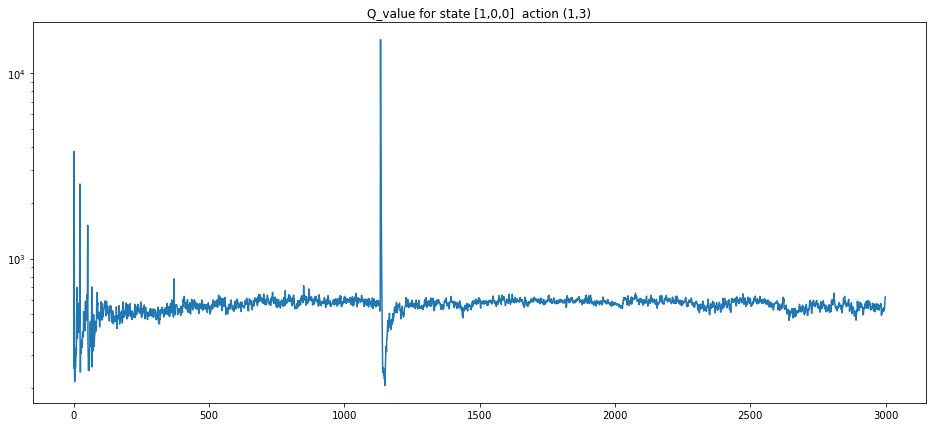

In [17]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,0,0]  action (1,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [13]:

score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

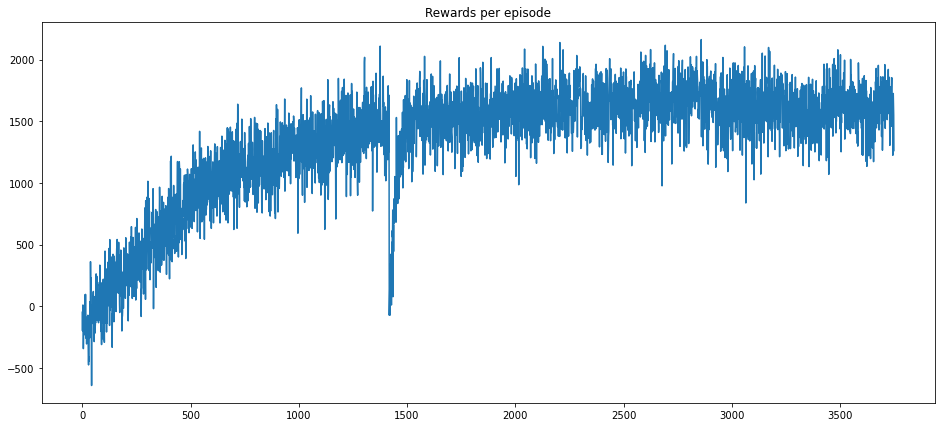

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

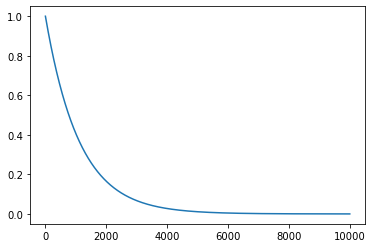

In [16]:
plt.plot(time, epsilon)
plt.show()